In [3]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd
import PIL

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from src.classification.utils import small_available_models

In [4]:
resize = Resize(128)

precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()

# Custom transform
def custom_transform(size):
    return Resize(size, method="pad", pad_mode="zeros")


class RGB2HSV(Transform):
    def encodes(self, img: PILImage):
        return rgb2hsv(img)
    

item_tfms = custom_transform(size=128)
batch_tfms = [
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ]

### Compare Different Models
In this section I will compare different Image classification models with the datasets created.
Classes are ordered as follow:
1. Amber
2. Clear
3. Cloudy
The order is determined by the order of folders in the dataset folder

In [5]:
import os

# iterate over each dataset in the datasets folder
balanced_datasets = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality/balanced_datasets"
data_paths = [os.path.join(balanced_datasets, dataset) for dataset in os.listdir(balanced_datasets)]


In [6]:
# from fastai.vision.all import *
# from collections import Counter
# import os

# # Define your batch size
# batch_size = 64

# for dataset_path in data_paths:
#     train_path = os.path.join(dataset_path, "train")
#     val_path = os.path.join(dataset_path, "val")
#     test_path = os.path.join(dataset_path, "test")
    
#     # Print the class distribution from the folders
#     train_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(train_path)])
#     val_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(val_path)])
#     test_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(test_path)])
    
#     print(f"--------- Dataset: {os.path.basename(dataset_path)} ---------")
#     print("Class Distribution from folders:")
#     print(f"Training Class Distribution: {train_dist}")
#     print(f"Validation Class Distribution: {val_dist}")
#     print(f"Test Class Distribution: {test_dist}")
    
#     # Define dataloaders
#     dls = ImageDataLoaders.from_folder(
#         path=dataset_path,
#         item_tfms=Resize(128),
#         bs=batch_size,
#         valid_pct=None  # Ensure no additional splitting
#     )

#     # Create the test DataLoader with the same transformations
#     test_files = get_image_files(test_path)
#     test_dl = dls.test_dl(test_files, with_labels=True)
    
#     # Retrieve datasets
#     train_ds = dls.train_ds
#     valid_ds = dls.valid_ds
#     test_ds = test_dl.dataset
    
#     # Decode labels
#     train_labels = [train_ds.decode(train_ds[i])[1] for i in range(len(train_ds))]
#     valid_labels = [valid_ds.decode(valid_ds[i])[1] for i in range(len(valid_ds))]
#     test_labels = [test_ds.decode(test_ds[i])[1] for i in range(len(test_ds))]

#     # Count label occurrences
#     train_label_counts = Counter(train_labels)
#     valid_label_counts = Counter(valid_labels)
#     test_label_counts = Counter(test_labels)
    
#     print("Class Distribution from dataloaders:")
#     print("Training Label Distribution:")
#     for label, count in train_label_counts.items():
#         print(f"{label}: {count}")

#     print("\nValidation Label Distribution:")
#     for label, count in valid_label_counts.items():
#         print(f"{label}: {count}")
        
#     print("\nTest Label Distribution:")
#     for label, count in test_label_counts.items():
#         print(f"{label}: {count}")


In [22]:
# TODO: I dont understand why the model preds are not good - check that out.


from fastai.vision.all import *
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import os

# fine tune hyperparameters
epochs = 10
batch_size = 64
lr = 1e-4
# Iterate over each dataset path
results = []
for dataset_path in data_paths:
    print(f"Training on dataset: {os.path.basename(dataset_path)}")
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "test")
    
    # Define DataLoaders with a validation split
    dls = ImageDataLoaders.from_folder(
        path=train_path,
        valid_pct=0.2,  # Reserve 20% of training data for validation
        seed=42,        # Ensure reproducibility
        item_tfms=Resize(128),
        bs=batch_size
    )
    
    for model_name, model_fn in small_available_models.items():
        print(f"Training model: {model_name}")
        
        model = vision_learner(
            dls=dls,
            arch=model_fn,
            metrics=[error_rate, precision_macro_fastai, recall_macro_fastai],
        )

        model.fine_tune(epochs=epochs)
        
        # Create the test DataLoader with the same transformations
        test_files = get_image_files(test_path)
        test_dl = dls.test_dl(test_files, with_labels=True)
        # Evaluate on the test set
        preds, targs = model.get_preds(dl=test_dl)
        pred_classes = preds.argmax(dim=1)
        true_classes = targs.numpy()


        precision = precision_score(true_classes, pred_classes, average='micro')
        recall = recall_score(true_classes, pred_classes, average='micro')
        precision_macro = precision_score(true_classes, pred_classes, average='macro')
        recall_macro = recall_score(true_classes, pred_classes, average='macro')
        accuracy = accuracy_score(true_classes, pred_classes)
        conf_matrix = confusion_matrix(true_classes, pred_classes)
        precision_per_class = precision_score(true_classes, pred_classes, average=None)
        recall_per_class = recall_score(true_classes, pred_classes, average=None)

        results.append({
            'dataset': os.path.basename(dataset_path),
            'model': model_name,
            'precision': precision,
            'recall': recall,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
        })
        
        print(f"------ Evaluation Results for model {model_name} ------")
        print(f"Precision Micro: {precision}")
        print(f"Recall Micro: {recall}")
        print(f"Precision Macro: {precision_macro}")
        print(f"Recall Macro: {recall_macro}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Precision per Class: {precision_per_class}")
        print(f"Recall per Class: {recall_per_class}")
        print("\n\n")
        



Training on dataset: train_set_1
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.703678,0.714481,0.300000,0.756023,0.689370,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.778169,0.528284,0.175000,0.852153,0.829533,00:00
1,0.643572,0.396954,0.141667,0.862568,0.859115,00:00
2,0.546609,0.332901,0.091667,0.908068,0.911592,00:00
3,0.470352,0.309940,0.108333,0.891716,0.896248,00:00
4,0.410266,0.252767,0.091667,0.908466,0.912650,00:00
5,0.351486,0.244071,0.100000,0.902735,0.904185,00:00
6,0.298044,0.243636,0.091667,0.912410,0.912121,00:00
7,0.253759,0.252474,0.091667,0.912410,0.912121,00:00
8,0.227173,0.251693,0.100000,0.905746,0.904185,00:00
9,0.204177,0.256490,0.100000,0.905746,0.904185,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9018867924528302
Recall Micro: 0.9018867924528302
Precision Macro: 0.854603948025987
Recall Macro: 0.880092192451743
Accuracy: 0.9018867924528302
Confusion Matrix:
[[ 83   2   4]
 [  0  21   5]
 [  9   6 135]]
Precision per Class: [0.90217391 0.72413793 0.9375    ]
Recall per Class: [0.93258427 0.80769231 0.9       ]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.538475,0.738426,0.350000,0.701898,0.651804,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.723450,0.401841,0.150000,0.851617,0.851130,00:01
1,0.577124,0.317407,0.125000,0.877924,0.878211,00:00
2,0.469051,0.357765,0.116667,0.889729,0.887783,00:00
3,0.357945,0.363188,0.100000,0.909057,0.905820,00:00
4,0.285192,0.340832,0.083333,0.929110,0.921164,00:00
5,0.228212,0.373301,0.091667,0.916370,0.913228,00:01
6,0.187762,0.393245,0.100000,0.905948,0.905820,00:00
7,0.155805,0.408330,0.100000,0.905948,0.905820,00:00
8,0.131338,0.409490,0.100000,0.905948,0.905820,00:00
9,0.113494,0.393639,0.100000,0.905948,0.905820,00:00


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.879245283018868
Recall Micro: 0.879245283018868
Precision Macro: 0.800027570995313
Recall Macro: 0.8743743397675982
Accuracy: 0.879245283018868
Confusion Matrix:
[[ 88   0   1]
 [  0  21   5]
 [  5  21 124]]
Precision per Class: [0.94623656 0.5        0.95384615]
Recall per Class: [0.98876404 0.80769231 0.82666667]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.629884,1.092828,0.500000,0.566556,0.512554,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.860323,1.010509,0.466667,0.583297,0.546561,00:01
1,0.761526,1.030926,0.408333,0.659112,0.599423,00:01
2,0.664016,0.910215,0.325000,0.689344,0.685907,00:01
3,0.593214,0.841757,0.283333,0.722650,0.727802,00:01
4,0.534111,0.725214,0.241667,0.759428,0.767003,00:01
5,0.504006,0.736476,0.191667,0.807714,0.819000,00:01
6,0.468342,0.703470,0.200000,0.804873,0.806734,00:01
7,0.431520,0.674122,0.216667,0.792347,0.791919,00:01
8,0.409179,0.658771,0.208333,0.800345,0.799327,00:01
9,0.386030,0.659130,0.208333,0.800016,0.799856,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7433962264150943
Recall Micro: 0.7433962264150943
Precision Macro: 0.681989247311828
Recall Macro: 0.7519177950638625
Accuracy: 0.7433962264150943
Confusion Matrix:
[[81  2  6]
 [ 0 18  8]
 [12 40 98]]
Precision per Class: [0.87096774 0.3        0.875     ]
Recall per Class: [0.91011236 0.69230769 0.65333333]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.477358,0.783900,0.416667,0.665744,0.600625,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.648323,0.738843,0.291667,0.723205,0.733333,00:01
1,0.598594,0.767460,0.283333,0.743348,0.742328,00:01
2,0.531392,0.716653,0.258333,0.777037,0.762915,00:01
3,0.498508,0.471533,0.158333,0.843525,0.852333,00:01
4,0.469551,0.439388,0.158333,0.842662,0.850216,00:01
5,0.421373,0.457223,0.183333,0.816037,0.827465,00:01
6,0.394161,0.431204,0.175000,0.824583,0.834873,00:01
7,0.358379,0.415606,0.175000,0.824583,0.834873,00:01
8,0.327688,0.429349,0.166667,0.833403,0.842280,00:01
9,0.306266,0.415772,0.166667,0.833403,0.842280,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.8603773584905661
Recall Micro: 0.8603773584905661
Precision Macro: 0.7733515593399075
Recall Macro: 0.8238528762124268
Accuracy: 0.8603773584905661
Confusion Matrix:
[[ 83   3   3]
 [  1  18   7]
 [  3  20 127]]
Precision per Class: [0.95402299 0.43902439 0.9270073 ]
Recall per Class: [0.93258427 0.69230769 0.84666667]



Training on dataset: train_set_2
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.646316,0.746477,0.275000,0.778879,0.715873,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.743782,0.565751,0.216667,0.800586,0.780616,00:00
1,0.622589,0.480371,0.166667,0.835664,0.839586,00:00
2,0.518173,0.443469,0.175000,0.825600,0.834343,00:00
3,0.431258,0.409021,0.141667,0.857247,0.866089,00:00
4,0.362525,0.399521,0.125000,0.875625,0.881433,00:00
5,0.306807,0.407629,0.100000,0.900475,0.905243,00:00
6,0.266314,0.408643,0.100000,0.900475,0.905243,00:00
7,0.233670,0.398284,0.100000,0.900253,0.907407,00:00
8,0.204570,0.380947,0.091667,0.908316,0.915344,00:00
9,0.178810,0.371794,0.091667,0.908316,0.915344,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9320754716981132
Recall Micro: 0.9320754716981132
Precision Macro: 0.8954064634349493
Recall Macro: 0.9236358398156151
Accuracy: 0.9320754716981132
Confusion Matrix:
[[ 86   0   3]
 [  0  23   3]
 [  6   6 138]]
Precision per Class: [0.93478261 0.79310345 0.95833333]
Recall per Class: [0.96629213 0.88461538 0.92      ]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.546871,0.869371,0.366667,0.699069,0.645599,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.680381,0.651157,0.266667,0.773681,0.742039,00:01
1,0.535163,0.493319,0.200000,0.819667,0.813131,00:00
2,0.433835,0.450410,0.141667,0.864088,0.866619,00:00
3,0.355551,0.433714,0.175000,0.828269,0.834343,00:00
4,0.281897,0.423261,0.133333,0.876043,0.873497,00:00
5,0.226089,0.413744,0.125000,0.883061,0.881433,00:00
6,0.183293,0.392788,0.125000,0.882264,0.881962,00:00
7,0.151627,0.389116,0.133333,0.874828,0.874026,00:00
8,0.127314,0.386632,0.133333,0.874828,0.874026,00:00
9,0.108448,0.378161,0.133333,0.874828,0.874026,00:00


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8716981132075472
Recall Micro: 0.8716981132075472
Precision Macro: 0.7968636350411685
Recall Macro: 0.85476231633535
Accuracy: 0.8716981132075472
Confusion Matrix:
[[ 85   2   2]
 [  0  20   6]
 [ 10  14 126]]
Precision per Class: [0.89473684 0.55555556 0.94029851]
Recall per Class: [0.95505618 0.76923077 0.84      ]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.573415,1.100621,0.525000,0.505869,0.485570,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.716817,1.166862,0.458333,0.592077,0.551804,00:01
1,0.695290,1.137570,0.400000,0.602724,0.616065,00:01
2,0.650589,0.944265,0.350000,0.671413,0.666955,00:01
3,0.594957,0.755098,0.291667,0.716878,0.727417,00:01
4,0.532858,0.779379,0.258333,0.747209,0.757576,00:01
5,0.488958,0.766832,0.258333,0.749158,0.757576,00:01
6,0.444603,0.780273,0.275000,0.733926,0.736845,00:01
7,0.412609,0.788598,0.275000,0.733608,0.740067,00:01
8,0.380400,0.775577,0.275000,0.734788,0.740067,00:01
9,0.359628,0.772775,0.291667,0.723077,0.719865,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7584905660377359
Recall Micro: 0.7584905660377359
Precision Macro: 0.6953455760720794
Recall Macro: 0.7880956496686834
Accuracy: 0.7584905660377359
Confusion Matrix:
[[85  1  3]
 [ 0 20  6]
 [22 32 96]]
Precision per Class: [0.79439252 0.37735849 0.91428571]
Recall per Class: [0.95505618 0.76923077 0.64      ]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.579599,1.005216,0.416667,0.688798,0.591967,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.694051,0.783629,0.308333,0.756019,0.711977,00:01
1,0.552094,0.749347,0.283333,0.752867,0.739057,00:01
2,0.478751,0.800916,0.241667,0.799524,0.777682,00:01
3,0.433939,0.653270,0.208333,0.813034,0.808947,00:01
4,0.397035,0.664695,0.241667,0.775054,0.778259,00:01
5,0.359214,0.707379,0.233333,0.785078,0.785666,00:01
6,0.338765,0.693613,0.208333,0.808030,0.808418,00:01
7,0.313283,0.674723,0.208333,0.808030,0.808418,00:01
8,0.280937,0.663904,0.200000,0.814286,0.815825,00:01
9,0.265944,0.647619,0.191667,0.817826,0.822703,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.8301886792452831
Recall Micro: 0.8301886792452831
Precision Macro: 0.7263957283165888
Recall Macro: 0.7561298377028715
Accuracy: 0.8301886792452831
Confusion Matrix:
[[ 85   1   3]
 [  1  13  12]
 [  9  19 122]]
Precision per Class: [0.89473684 0.39393939 0.89051095]
Recall per Class: [0.95505618 0.5        0.81333333]



Training on dataset: train_set_3
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.518672,0.696717,0.308333,0.731520,0.686821,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.723317,0.519011,0.241667,0.777453,0.766522,00:00
1,0.610903,0.474846,0.183333,0.821952,0.826407,00:00
2,0.510752,0.410986,0.141667,0.863747,0.865031,00:00
3,0.428094,0.375295,0.125000,0.875423,0.882492,00:00
4,0.357096,0.391933,0.108333,0.893762,0.897306,00:00
5,0.302053,0.411458,0.116667,0.886695,0.889370,00:00
6,0.254074,0.426432,0.125000,0.879837,0.881433,00:00
7,0.216352,0.428587,0.125000,0.879837,0.881433,00:00
8,0.194311,0.419818,0.125000,0.877969,0.881962,00:00
9,0.173305,0.414967,0.125000,0.877969,0.881962,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.8905660377358491
Recall Micro: 0.8905660377358491
Precision Macro: 0.8274932781160182
Recall Macro: 0.9097896859694612
Accuracy: 0.8905660377358491
Confusion Matrix:
[[ 86   0   3]
 [  0  24   2]
 [  9  15 126]]
Precision per Class: [0.90526316 0.61538462 0.96183206]
Recall per Class: [0.96629213 0.92307692 0.84      ]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.564225,0.558842,0.233333,0.789962,0.762530,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.693502,0.498237,0.208333,0.800087,0.793362,00:01
1,0.567279,0.427182,0.166667,0.838821,0.837951,00:00
2,0.442520,0.424753,0.141667,0.861243,0.866619,00:00
3,0.358615,0.468299,0.141667,0.863826,0.866089,00:00
4,0.277458,0.486899,0.133333,0.869422,0.874026,00:00
5,0.224469,0.501666,0.125000,0.879465,0.881433,00:00
6,0.183352,0.494054,0.100000,0.902470,0.905243,00:00
7,0.157803,0.493750,0.108333,0.895121,0.897835,00:00
8,0.134066,0.483079,0.116667,0.886958,0.889899,00:00
9,0.115112,0.477431,0.108333,0.895121,0.897835,00:00


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8528301886792453
Recall Micro: 0.8528301886792453
Precision Macro: 0.7841196051423324
Recall Macro: 0.8860443676174015
Accuracy: 0.8528301886792453
Confusion Matrix:
[[ 85   1   3]
 [  1  24   1]
 [ 10  23 117]]
Precision per Class: [0.88541667 0.5        0.96694215]
Recall per Class: [0.95505618 0.92307692 0.78      ]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.541465,0.918739,0.425000,0.625066,0.580279,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.869749,1.110634,0.441667,0.643333,0.560606,00:01
1,0.765473,0.850629,0.341667,0.683723,0.669986,00:01
2,0.677108,0.780478,0.275000,0.728410,0.740596,00:01
3,0.654836,0.800964,0.283333,0.715898,0.736989,00:01
4,0.575653,0.748681,0.275000,0.724450,0.743867,00:01
5,0.518958,0.649611,0.241667,0.760573,0.774026,00:01
6,0.473900,0.601396,0.216667,0.785517,0.795142,00:01
7,0.448447,0.590294,0.208333,0.792663,0.805243,00:01
8,0.413313,0.574010,0.200000,0.800678,0.813179,00:01
9,0.395579,0.568040,0.191667,0.810090,0.820058,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7509433962264151
Recall Micro: 0.7509433962264151
Precision Macro: 0.6978958299174728
Recall Macro: 0.7896802074330164
Accuracy: 0.7509433962264151
Confusion Matrix:
[[82  1  6]
 [ 0 21  5]
 [13 41 96]]
Precision per Class: [0.86315789 0.33333333 0.89719626]
Recall per Class: [0.92134831 0.80769231 0.64      ]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.544442,0.751698,0.333333,0.709480,0.682251,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.678153,0.719928,0.316667,0.716667,0.706205,00:01
1,0.611826,0.742901,0.241667,0.765091,0.778259,00:01
2,0.565676,0.587065,0.200000,0.801337,0.814238,00:02
3,0.494020,0.714489,0.183333,0.826582,0.830640,00:02
4,0.458219,0.692980,0.175000,0.832561,0.835354,00:01
5,0.416726,0.599000,0.166667,0.834656,0.841703,00:01
6,0.396255,0.605198,0.175000,0.826561,0.832708,00:01
7,0.364099,0.591854,0.166667,0.836671,0.840645,00:01
8,0.335655,0.576112,0.166667,0.836671,0.840645,00:01
9,0.319900,0.574703,0.158333,0.845351,0.848052,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.7547169811320755
Recall Micro: 0.7547169811320755
Precision Macro: 0.6942460317460317
Recall Macro: 0.7495092672620762
Accuracy: 0.7547169811320755
Confusion Matrix:
[[ 82   4   3]
 [  1  17   8]
 [  7  42 101]]
Precision per Class: [0.91111111 0.26984127 0.90178571]
Recall per Class: [0.92134831 0.65384615 0.67333333]



Training on dataset: train_set_4
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.675192,0.645577,0.283333,0.782108,0.715007,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.845348,0.466581,0.200000,0.827302,0.801395,00:00
1,0.718131,0.346304,0.133333,0.875757,0.871910,00:00
2,0.609278,0.281544,0.116667,0.886781,0.888841,00:00
3,0.515792,0.211361,0.100000,0.900475,0.905243,00:00
4,0.427964,0.193518,0.075000,0.928412,0.928523,00:00
5,0.358534,0.232508,0.083333,0.920587,0.920587,00:00
6,0.304423,0.245887,0.100000,0.902705,0.905243,00:00
7,0.263201,0.250623,0.100000,0.902705,0.905243,00:00
8,0.229140,0.252939,0.100000,0.902705,0.905243,00:00
9,0.208997,0.249787,0.091667,0.910407,0.913179,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9358490566037736
Recall Micro: 0.9358490566037736
Precision Macro: 0.8823009816013979
Recall Macro: 0.9289042542975127
Accuracy: 0.9358490566037736
Confusion Matrix:
[[ 88   0   1]
 [  0  23   3]
 [  4   9 137]]
Precision per Class: [0.95652174 0.71875    0.97163121]
Recall per Class: [0.98876404 0.88461538 0.91333333]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.766717,0.531768,0.241667,0.762685,0.762145,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.667281,0.498634,0.225000,0.785417,0.779076,00:01
1,0.571020,0.412001,0.175000,0.828042,0.836460,00:00
2,0.450011,0.349721,0.133333,0.871429,0.875613,00:00
3,0.364250,0.307067,0.125000,0.881205,0.883021,00:00
4,0.287345,0.301964,0.116667,0.890254,0.889370,00:00
5,0.231449,0.350223,0.116667,0.891618,0.888841,00:00
6,0.191793,0.373656,0.108333,0.900530,0.896248,00:00
7,0.161624,0.382398,0.116667,0.893288,0.887783,00:00
8,0.135763,0.357695,0.091667,0.918861,0.913757,00:00
9,0.115234,0.359523,0.091667,0.918861,0.913757,00:00


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8830188679245283
Recall Micro: 0.8830188679245283
Precision Macro: 0.8092632005675484
Recall Macro: 0.8705041774704695
Accuracy: 0.8830188679245283
Confusion Matrix:
[[ 84   0   5]
 [  1  21   4]
 [  3  18 129]]
Precision per Class: [0.95454545 0.53846154 0.93478261]
Recall per Class: [0.94382022 0.80769231 0.86      ]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.552295,1.071899,0.475000,0.535325,0.548341,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.911026,0.823120,0.408333,0.658143,0.604810,00:01
1,0.826318,0.830096,0.333333,0.677739,0.674747,00:01
2,0.741329,0.820235,0.300000,0.698860,0.724339,00:01
3,0.681856,0.876472,0.291667,0.710954,0.726359,00:01
4,0.621539,0.874711,0.291667,0.711162,0.723665,00:01
5,0.579735,0.785114,0.283333,0.719194,0.736460,00:01
6,0.532976,0.743640,0.241667,0.768651,0.776142,00:01
7,0.515927,0.734587,0.250000,0.760231,0.768206,00:01
8,0.478389,0.710528,0.250000,0.759542,0.767677,00:01
9,0.442818,0.704740,0.241667,0.767663,0.775613,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7358490566037735
Recall Micro: 0.7358490566037735
Precision Macro: 0.6831155686418845
Recall Macro: 0.7489964467492557
Accuracy: 0.7358490566037735
Confusion Matrix:
[[82  4  3]
 [ 2 18  6]
 [11 44 95]]
Precision per Class: [0.86315789 0.27272727 0.91346154]
Recall per Class: [0.92134831 0.69230769 0.63333333]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.660654,0.781486,0.375000,0.685290,0.645214,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.697976,0.673996,0.333333,0.708658,0.693025,00:01
1,0.668594,0.610211,0.250000,0.761111,0.771958,00:01
2,0.598368,0.541644,0.241667,0.761611,0.776190,00:01
3,0.532738,0.460590,0.183333,0.822665,0.829052,00:01
4,0.476864,0.444336,0.158333,0.846891,0.852333,00:01
5,0.432531,0.461510,0.166667,0.839855,0.845503,00:01
6,0.384702,0.496601,0.183333,0.825056,0.827465,00:01
7,0.359678,0.509052,0.166667,0.840175,0.843338,00:01
8,0.334253,0.498952,0.175000,0.832547,0.835402,00:01
9,0.315782,0.495255,0.183333,0.825056,0.827465,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.8377358490566038
Recall Micro: 0.8377358490566038
Precision Macro: 0.7514698212507706
Recall Macro: 0.8105195428790934
Accuracy: 0.8377358490566038
Confusion Matrix:
[[ 83   2   4]
 [  2  18   6]
 [  7  22 121]]
Precision per Class: [0.90217391 0.42857143 0.92366412]
Recall per Class: [0.93258427 0.69230769 0.80666667]



Training on dataset: train_set_5
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.721131,0.579504,0.258333,0.783163,0.737133,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.715307,0.434337,0.175000,0.828836,0.834343,00:00
1,0.620213,0.338880,0.133333,0.868777,0.875661,00:00
2,0.537798,0.322732,0.116667,0.885827,0.891005,00:00
3,0.448319,0.285611,0.100000,0.900685,0.906349,00:01
4,0.371973,0.251512,0.091667,0.906898,0.914815,00:00
5,0.309195,0.253900,0.091667,0.906898,0.914815,00:00
6,0.263494,0.262080,0.100000,0.898657,0.907407,00:00
7,0.226761,0.274508,0.100000,0.898657,0.907407,00:00
8,0.198696,0.263919,0.091667,0.906898,0.914815,00:00
9,0.173150,0.268401,0.091667,0.906898,0.914815,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9169811320754717
Recall Micro: 0.9169811320754717
Precision Macro: 0.8893914807302231
Recall Macro: 0.9268683376548545
Accuracy: 0.9169811320754717
Confusion Matrix:
[[ 87   0   2]
 [  0  24   2]
 [ 13   5 132]]
Precision per Class: [0.87       0.82758621 0.97058824]
Recall per Class: [0.97752809 0.92307692 0.88      ]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.565796,0.649036,0.266667,0.751465,0.732949,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.775324,0.584913,0.250000,0.787955,0.749832,00:01
1,0.576246,0.534090,0.250000,0.776954,0.760606,00:00
2,0.434623,0.521546,0.208333,0.800359,0.804666,00:01
3,0.352042,0.432380,0.158333,0.844505,0.846946,00:00
4,0.281592,0.302466,0.116667,0.887369,0.890428,00:00
5,0.232631,0.256412,0.091667,0.912509,0.915344,00:00
6,0.196913,0.258831,0.075000,0.928046,0.930688,00:00
7,0.166486,0.262825,0.075000,0.926326,0.930159,00:00
8,0.139506,0.259204,0.075000,0.926326,0.930159,00:00
9,0.117713,0.250676,0.075000,0.926326,0.930159,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8716981132075472
Recall Micro: 0.8716981132075472
Precision Macro: 0.7973971709746079
Recall Macro: 0.8774819936617689
Accuracy: 0.8716981132075472
Confusion Matrix:
[[ 86   0   3]
 [  1  22   3]
 [  7  20 123]]
Precision per Class: [0.91489362 0.52380952 0.95348837]
Recall per Class: [0.96629213 0.84615385 0.82      ]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.506249,0.929518,0.466667,0.558580,0.527754,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.697177,0.890952,0.425000,0.597002,0.567965,00:01
1,0.718536,0.690728,0.325000,0.701076,0.679990,00:01
2,0.624809,0.662454,0.258333,0.767882,0.752140,00:01
3,0.567377,0.667613,0.266667,0.734053,0.747475,00:01
4,0.528400,0.653276,0.233333,0.770370,0.784608,00:01
5,0.490415,0.708520,0.250000,0.758011,0.767100,00:01
6,0.465686,0.688159,0.250000,0.749682,0.764983,00:01
7,0.430277,0.667292,0.250000,0.750120,0.764454,00:01
8,0.408095,0.651008,0.233333,0.768620,0.780327,00:01
9,0.399857,0.664442,0.225000,0.775995,0.787734,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7886792452830189
Recall Micro: 0.7886792452830189
Precision Macro: 0.7338515487093429
Recall Macro: 0.8436973014501105
Accuracy: 0.7886792452830189
Confusion Matrix:
[[ 82   2   5]
 [  1  24   1]
 [ 12  35 103]]
Precision per Class: [0.86315789 0.39344262 0.94495413]
Recall per Class: [0.92134831 0.92307692 0.68666667]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.508577,1.155795,0.458333,0.657618,0.545791,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.689449,0.983743,0.416667,0.663316,0.601154,00:01
1,0.630119,0.867531,0.308333,0.725872,0.718470,00:01
2,0.556000,0.752521,0.283333,0.734589,0.734247,00:01
3,0.479673,0.600130,0.233333,0.783596,0.774363,00:01
4,0.433525,0.504103,0.191667,0.808838,0.815729,00:01
5,0.402126,0.606556,0.216667,0.783160,0.795142,00:01
6,0.366316,0.615628,0.216667,0.783892,0.792977,00:01
7,0.332172,0.603036,0.216667,0.785280,0.792977,00:01
8,0.315317,0.596038,0.216667,0.787016,0.792448,00:01
9,0.298168,0.578547,0.208333,0.796461,0.797691,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.8226415094339623
Recall Micro: 0.8226415094339623
Precision Macro: 0.7371506138946083
Recall Macro: 0.8016306539902045
Accuracy: 0.8226415094339623
Confusion Matrix:
[[ 83   4   2]
 [  2  18   6]
 [  8  25 117]]
Precision per Class: [0.89247312 0.38297872 0.936     ]
Recall per Class: [0.93258427 0.69230769 0.78      ]





In [23]:
results_df = pd.DataFrame(results)
results_df.head()

,dataset,model,precision,recall,precision_macro,recall_macro,precision_per_class,recall_per_class,accuracy,confusion_matrix
0,train_set_1,alexnet,0.901887,0.901887,0.854604,0.880092,"[0.9021739130434783, 0.7241379310344828, 0.9375]","[0.9325842696629213, 0.8076923076923077, 0.9]",0.901887,"[[83, 2, 4], [0, 21, 5], [9, 6, 135]]"
1,train_set_1,resnet34,0.879245,0.879245,0.800028,0.874374,"[0.946236559139785, 0.5, 0.9538461538461539]","[0.9887640449438202, 0.8076923076923077, 0.8266666666666667]",0.879245,"[[88, 0, 1], [0, 21, 5], [5, 21, 124]]"
2,train_set_1,efficientnet_b0,0.743396,0.743396,0.681989,0.751918,"[0.8709677419354839, 0.3, 0.875]","[0.9101123595505618, 0.6923076923076923, 0.6533333333333333]",0.743396,"[[81, 2, 6], [0, 18, 8], [12, 40, 98]]"
3,train_set_1,efficientnet_b1,0.860377,0.860377,0.773352,0.823853,"[0.9540229885057471, 0.43902439024390244, 0.927007299270073]","[0.9325842696629213, 0.6923076923076923, 0.8466666666666667]",0.860377,"[[83, 3, 3], [1, 18, 7], [3, 20, 127]]"
4,train_set_2,alexnet,0.932075,0.932075,0.895406,0.923636,"[0.9347826086956522, 0.7931034482758621, 0.9583333333333334]","[0.9662921348314607, 0.8846153846153846, 0.92]",0.932075,"[[86, 0, 3], [0, 23, 3], [6, 6, 138]]"


In [27]:
results_csv_path = "/home/etaylor/code_projects/thesis/src/classification/notebooks/trichome_classification/evaluation_results/fastai_classification_small models_to_datasets.csv"
average_results_csv_path = "/home/etaylor/code_projects/thesis/src/classification/notebooks/trichome_classification/evaluation_results/fastai_classification_small models_to_datasets_average_results.csv"

In [28]:
results_df.to_csv(results_csv_path, index=False)

For Loading the results without running the code again use the code below

In [ ]:
results_df = pd.read_csv(results_csv_path)
results_df.head()

In [24]:
import numpy as np
# create an average result dataframe for each of the models
average_results = []

for model_name in results_df['model'].unique():
    model_results = results_df[results_df['model'] == model_name]
    
    average_results.append({
        'model': model_name,
        'precision': model_results['precision'].mean(),
        'recall': model_results['recall'].mean(),
        'precision_macro': model_results['precision_macro'].mean(),
        'recall_macro': model_results['recall_macro'].mean(),
        'accuracy': model_results['accuracy'].mean(),
        'precision_per_class': model_results['precision_per_class'].mean(axis=0),
        'recall_per_class': model_results['recall_per_class'].mean(axis=0),
        'confusion_matrix': model_results['confusion_matrix'].mean(axis=0),
    })
average_results_df = pd.DataFrame(average_results)
average_results_df.head()

,model,precision,recall,precision_macro,recall_macro,accuracy,precision_per_class,recall_per_class,confusion_matrix
0,alexnet,0.915472,0.915472,0.869839,0.913858,0.915472,"[0.9137482837528605, 0.7357924403183024, 0.9599769670739825]","[0.9662921348314608, 0.8846153846153847, 0.8906666666666666]","[[86.0, 0.4, 2.6], [0.0, 23.0, 3.0], [8.2, 8.2, 133.6]]"
1,resnet34,0.871698,0.871698,0.797534,0.872633,0.871698,"[0.9191658278956891, 0.5235653235653236, 0.9498715581715693]","[0.9617977528089888, 0.8307692307692307, 0.8253333333333333]","[[85.6, 0.6, 2.8], [0.6, 21.6, 3.8], [7.0, 19.2, 123.8]]"
2,efficientnet_b0,0.755472,0.755472,0.698440,0.784477,0.755472,"[0.8509667899020993, 0.33537234391549264, 0.9089795285739726]","[0.9258426966292135, 0.776923076923077, 0.6506666666666667]","[[82.4, 2.0, 4.6], [0.6, 20.2, 5.2], [14.0, 38.4, 97.6]]"
3,efficientnet_b1,0.821132,0.821132,0.736523,0.788328,0.821132,"[0.9109035946090339, 0.38287104120005006, 0.9157936169196603]","[0.9348314606741572, 0.6461538461538462, 0.784]","[[83.2, 2.8, 3.0], [1.4, 16.8, 7.8], [6.8, 25.6, 117.6]]"


In [29]:
average_results_df.to_csv(average_results_csv_path, index=False)

In [ ]:
# Load the average results
average_results_df = pd.read_csv(average_results_csv_path)
average_results_df.head()

### Plot the evaluation results

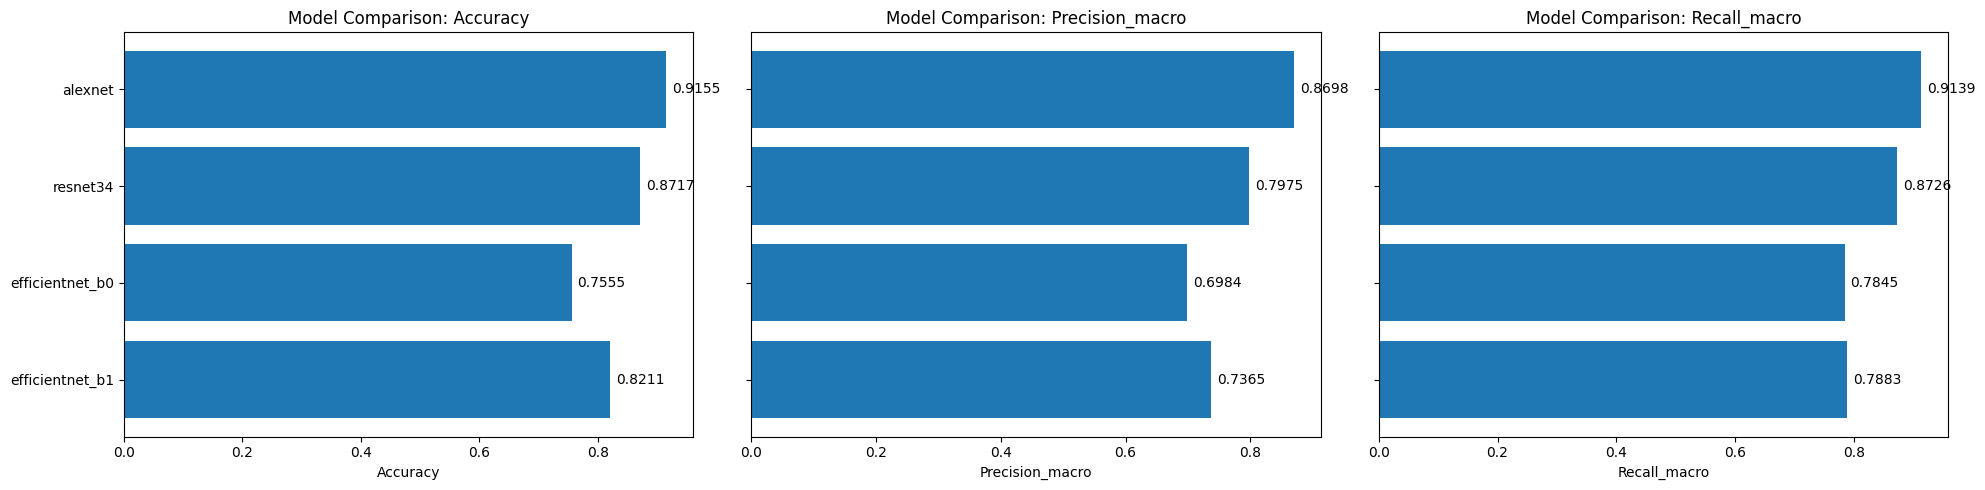

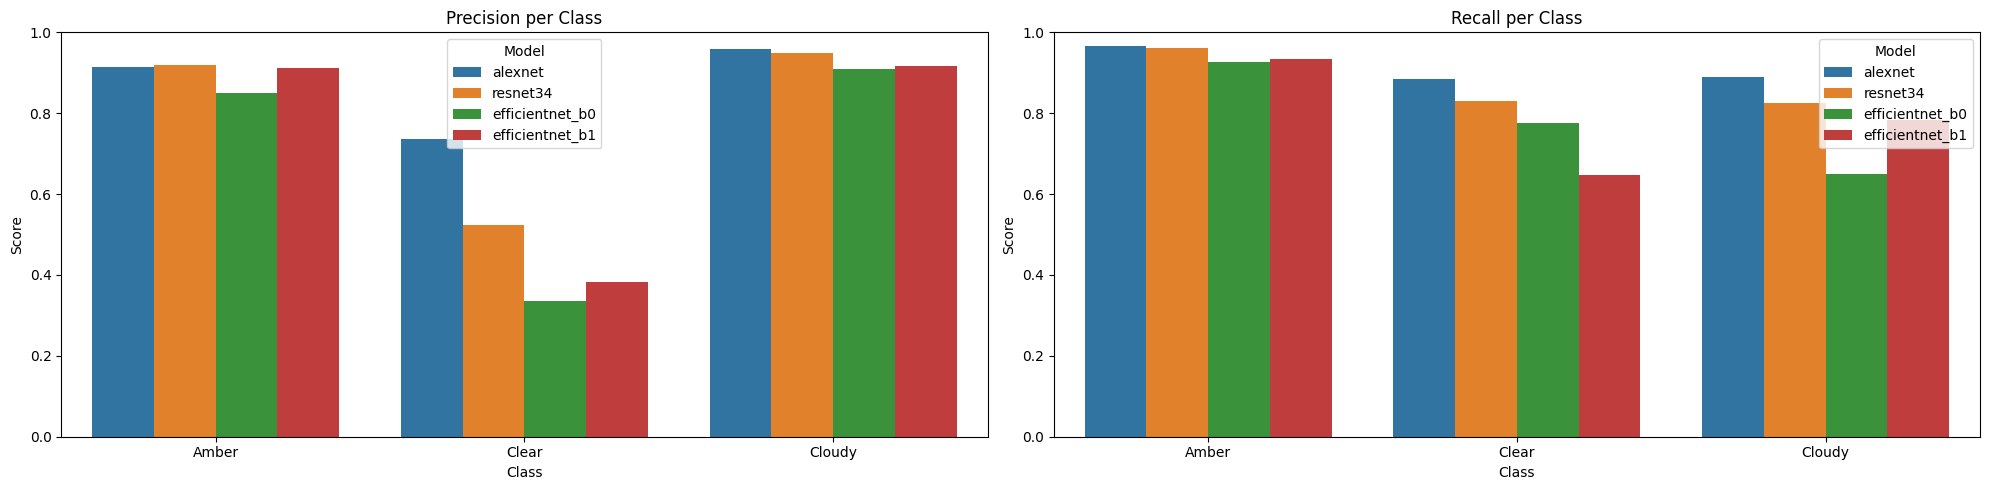

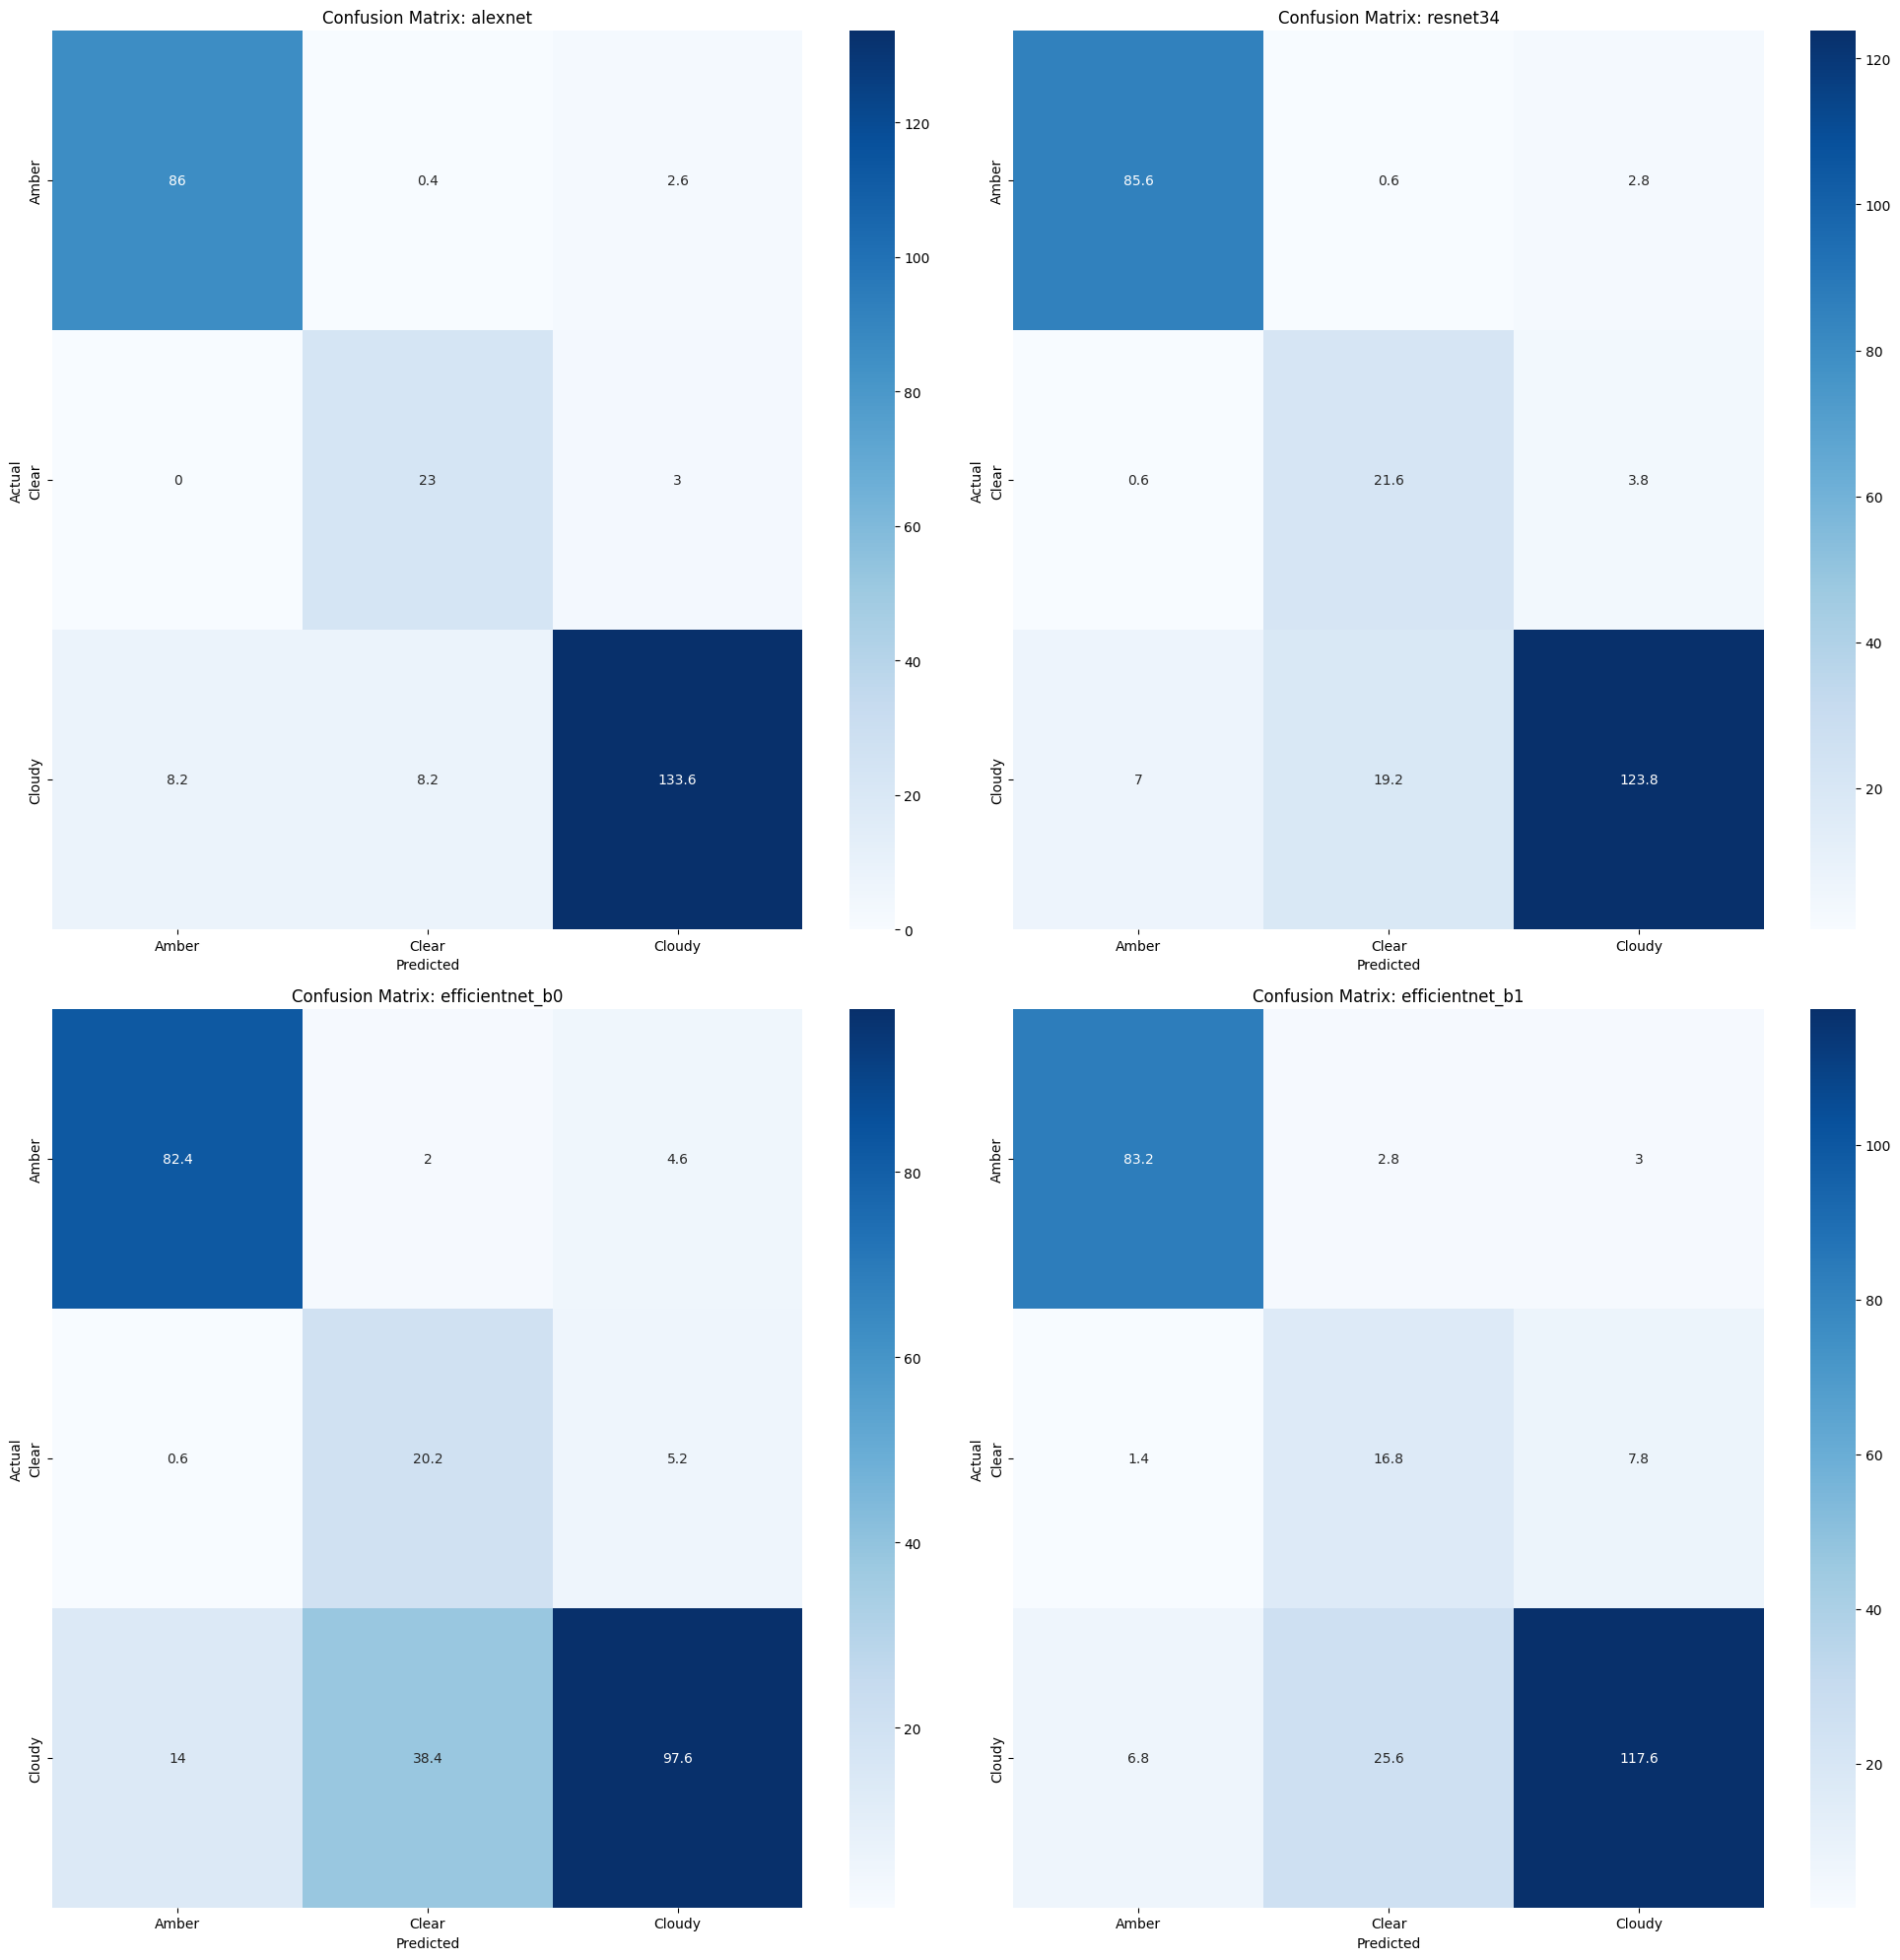

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting metrics for each model
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro"]
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metric_values = average_results_df[metric]
    models = average_results_df['model']
    y_pos = np.arange(len(models))

    axes[i].barh(y_pos, metric_values, align='center')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(models)
    axes[i].invert_yaxis()
    axes[i].set_xlabel(metric.capitalize())
    axes[i].set_title(f'Model Comparison: {metric.capitalize()}')

    for j in range(len(models)):
        axes[i].text(metric_values[j] + 0.01, y_pos[j], f'{metric_values[j]:.4f}', va='center')

plt.tight_layout()
plt.show()

# Plot precision and recall for each class
class_labels = ['Amber', 'Clear', 'Cloudy']

# Prepare precision and recall data for plotting
precision_data = []
recall_data = []
for i, row in average_results_df.iterrows():
    model_name = row['model']
    precision_per_class = row['precision_per_class']
    recall_per_class = row['recall_per_class']
    for j, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
        precision_data.append({'Model': model_name, 'Class': class_labels[j], 'Score': precision})
        recall_data.append({'Model': model_name, 'Class': class_labels[j], 'Score': recall})

precision_df = pd.DataFrame(precision_data)
recall_df = pd.DataFrame(recall_data)

# Plot class-wise precision and recall
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0])
axes[0].set_title('Precision per Class')
axes[0].set_ylim(0, 1)

sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1])
axes[1].set_title('Recall per Class')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Plot confusion matrices for each model
num_models = len(average_results_df)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

for i, (index, row) in enumerate(average_results_df.iterrows()):
    cm = np.array(row['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axes[i],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[i].set_title(f'Confusion Matrix: {row["model"]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#TODO NEXT
"""
V - try to understand how can i improve the use of the dinov2 (for start it didnt recieve the best results)
V - compare more classifiers on the dinov2
- try more models that convert the images to embeddings and then with classifiers
- try to see if i can apply thresholds based on colors or other features to cluster or classify the trichomes
- try to see if i can apply some kind of clustering to the images and then classify them
- try to see if i can apply some kind of clustering to the embeddings and then classify them.
- check if i can do more transformations like i did in the time series course to the data in order to perform classification.
"""